# Global Optimization

This section provides implementation for the concepts covered in the class for global optimization.
Each subsection contains various code blocks which provide python implementation for the concept. 
You are expected to create an empty jupyter notebook, and paste the code in the notebook and run it. 
This will teach you how to create notebooks from scratch and prepare you for workbook and homework 
assignments. Following topics are covered in this section:

1. Multi-start Gradient-based optimization
2. Particle Swarm Optimization
3. Differential Evolution

(intro:jones-function)=
## Jones Function

All the above algorithms will be tested on the Jones function which is a fourth-order smooth multimodal function, defined as:

$$
    f(x_1, x_2) = x_1^4 + x_2^4 - 4x_1^3 - 3x_2^3 + 2x_1^2 + 2x_1x_2
$$

As we have been doing in previous notebooks, we will plot the function contours. It is very important to have some insights/understanding of the design space. Below block of code imports required packages and defines couple of functions for plotting purposes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def jones_function(x):
    """
        Function to evaluate values of jones function at any given x.
        
        Input:
        x - 1d numpy array containing only two entries. First entry is x1
        and 2nd entry is x2.
    """
    
    # Number of dimensions of input
    dim = x.ndim

    # Converting to 2D numpy array if input is 1D
    if dim == 1:
        x = x.reshape(1,-1)

    x1 = x[:,0]
    x2 = x[:,1]

    y = x1**4 + x2**4 - 4*x1**3 - 3*x2**3 + 2*x1**2 + 2*x1*x2

    y = y.reshape(-1,1)
    
    if dim == 1:
        y = y.reshape(-1,)

    return y

def plot_jones_function(ax=None):
    """
        Function which plots the jones function

        Input:
        ax (optional) - matplotlib axis object. If not provided, a new figure is created

        Returns ax object containing jones function plot
    """

    num_points = 50

    # Defining x and y values
    x = np.linspace(-2,4,num_points)
    y = np.linspace(-2,4,num_points)

    # Creating a mesh at which values will be evaluated and plotted
    X, Y = np.meshgrid(x, y)

    # Evaluating the function values at meshpoints
    Z = jones_function(np.hstack((X.reshape(-1,1),Y.reshape(-1,1)))).reshape(num_points,num_points)

    Z = Z.reshape(X.shape)

    # Denoting at which level to add contour lines
    levels = np.arange(-13,-5,1)
    levels = np.concatenate((levels, np.arange(-4, 8, 3)))
    levels = np.concatenate((levels, np.arange(10, 100, 15)))

    # Plotting the contours
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))

    CS = ax.contour(X, Y, Z, levels=levels, colors="k", linestyles="solid")
    ax.clabel(CS, inline=1, fontsize=8)
    ax.set_xlabel("$x_1$", fontsize=14)
    ax.set_ylabel("$x_2$", fontsize=14)
    ax.set_title("Jones Function", fontsize=14)

    return ax

Below block of plots the jones function using previously defined functions:

<Axes: title={'center': 'Jones Function'}, xlabel='$x_1$', ylabel='$x_2$'>

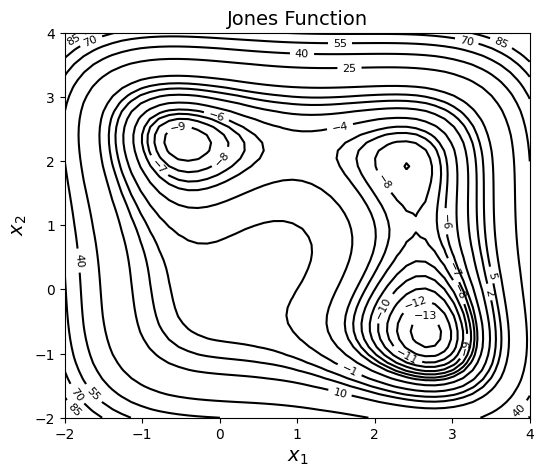

In [52]:
plot_jones_function()

> **_NOTE:_** A logscaled filled contour is needed to better visualize the design space. But there are many negative function values in the region and it is not possibile to take log of negative values. So, only line contours are plotted.

As can be seen in contour plot, function has three regions of attraction which leads to three different minima (one of them is global):

Local minima: $f(x^*) = -9.0312$ at $x^* = (2.4239,1.9219)$

&emsp; &emsp; &emsp; &emsp; &emsp; $f(x^*) = -9.7770$ at $x^* = (-0.4495, 2.2928)$

Global minimum: $f(x^*) = -13.5320$ at $x^* = (2.6732,-0.6759)$

Before starting with global optimization, we will do simple unconstrained gradient based optimization with different starting points and note the results. Below block of code defines various required functions.

In [77]:
def jones_opt_history(x):
    """
        Function which is called after every iteration of optimization.
        It stores the value of x1, x2, and function value which is later
        for plotting convergence history.
        
        Input: 
        x - 1d numpy array which contains current x values
    """
    
    history["x1"].append(x[0])
    history["x2"].append(x[1])
    history["f"].append(jones_function(x))

def jones_opt_plots(history, starting_point, result):
    """
        Function used for plotting the results of the optimization.
        
        Input:

        history - A dictionary which contains three key-value pairs - x1, x2, and f.
        Each of this pair should be a list which contains values of 
        the respective quantity at each iteration. Look at the usage of this
        function in following blocks for better understanding.

        starting_point - A 1D numpy array containing the starting point of the
        optimization.

        result - A scipy.optimize.OptimizeResult object which contains the result
    """
    
    # Number of iterations.
    # Subtracting 1, since it also contains starting point
    num_itr = len(history["x1"]) - 1

    # Plotting the convergence history
    fig, ax = plt.subplots(1, 2, figsize=(16,6))

    ax[0] = plot_jones_function(ax[0])
    ax[0].plot(history["x1"], history["x2"], "k--", marker=".", label="Path", zorder=5.0)
    ax[0].scatter(starting_point[0], starting_point[1], label="Starting point", c="red", zorder=10.0)
    ax[0].scatter(result.x[0], result.x[1], label="Final point", c="green", zorder=10.0)
    ax[0].set_title("Path of optimizer - starting point: {}".format(starting_point), fontsize=14)
    ax[0].legend(loc="upper left", fontsize=12)

    ax[1].plot(np.arange(num_itr+1), history["x1"], "k", marker=".", label="$x_1$")
    ax[1].plot(np.arange(num_itr+1), history["x2"], "b", marker=".", label="$x_2$")
    ax[1].plot(np.arange(num_itr+1), history["f"], "g", marker=".", label="$f$")
    ax[1].set_xlabel("Iterations", fontsize=14)
    ax[1].set_xlim(left=0, right=num_itr)
    ax[1].set_ylabel("Quantities", fontsize=14)
    ax[1].grid()
    ax[1].legend(fontsize=12)
    ax[1].set_title("Convergence history", fontsize=14)    

Below block of code defines various optimization parameters and performs optimization with $x_0 = (1.5, 3.5)$

Optimization terminated successfully.
         Current function value: -9.031204
         Iterations: 9
         Function evaluations: 60
         Gradient evaluations: 12
Value of x1 at optimum: 2.423878687788307
Value of x2 at optimum: 1.921885060897981


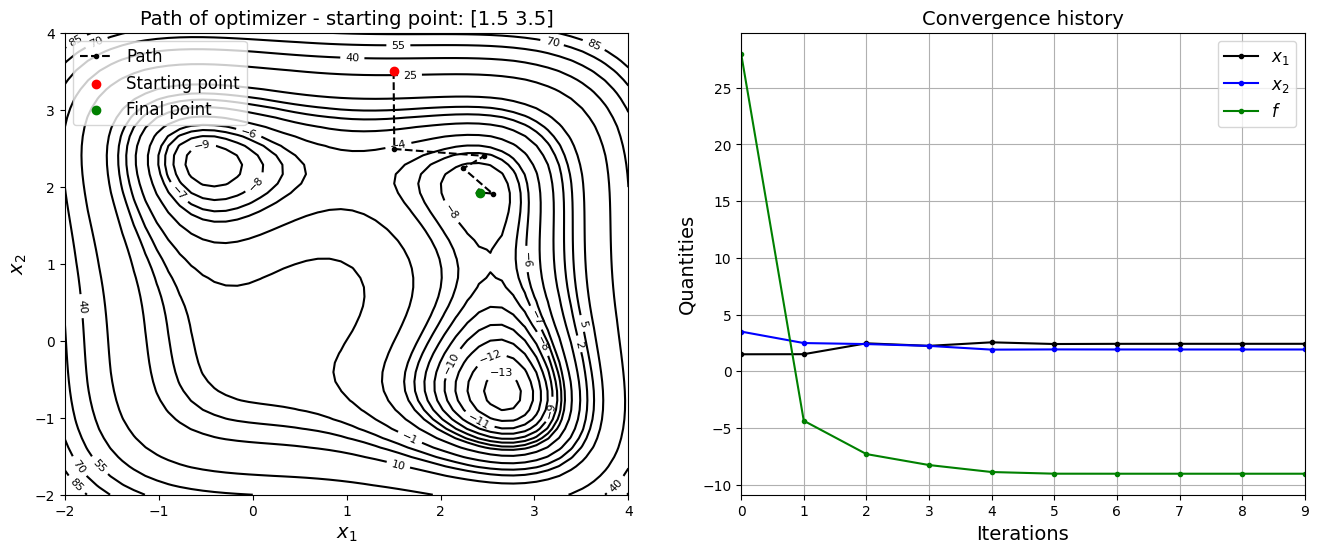

In [79]:
# Solver
method = "BFGS"

# Finite difference scheme
jac = "3-point"

# Solver options
options ={
    "disp": True
}

# Starting point
x0 = np.array([1.5, 3.5])

# Defining dict for storing history of optimization
history = {}
history["x1"] = [x0[0]]
history["x2"] = [x0[1]]
history["f"] = [jones_function(x0)]

# Minimize the function
result = minimize(fun=jones_function, x0=x0, method=method, jac=jac, callback=jones_opt_history, options=options)

# Print value of x
print("Value of x1 at optimum: {}".format(result.x[0]))
print("Value of x2 at optimum: {}".format(result.x[1]))

# Convergence plots
jones_opt_plots(history, x0, result)

Now, the starting point is changed to $x_0 = (-1, 0)$ and optimization is performed.

Optimization terminated successfully.
         Current function value: -9.776964
         Iterations: 7
         Function evaluations: 80
         Gradient evaluations: 16
Value of x1 at optimum: -0.449477680481256
Value of x2 at optimum: 2.292752715159829


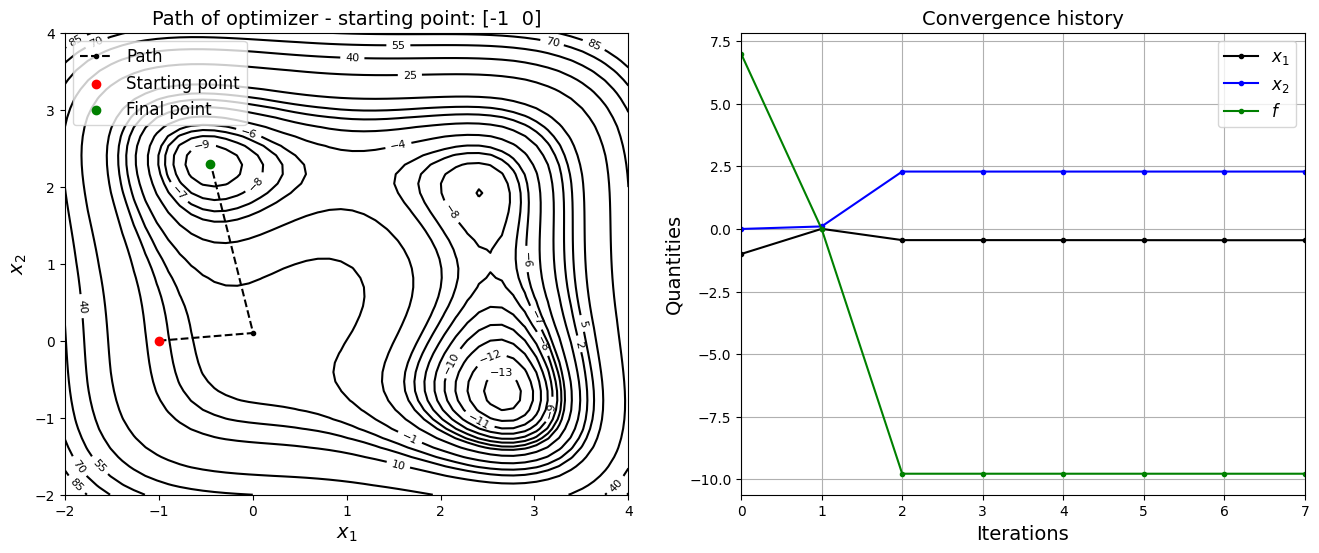

In [80]:
x0 = np.array([-1, 0])

# Defining dict for storing history of optimization
history = {}
history["x1"] = [x0[0]]
history["x2"] = [x0[1]]
history["f"] = [jones_function(x0)]

# Minimize the function
result = minimize(fun=jones_function, x0=x0, method=method, jac=jac, callback=jones_opt_history, options=options)

# Print value of x
print("Value of x1 at optimum: {}".format(result.x[0]))
print("Value of x2 at optimum: {}".format(result.x[1]))

# Convergence plots
jones_opt_plots(history, x0, result)

Now, the starting point is changed to $x_0 = (-1, -1)$ and optimization is performed.

Optimization terminated successfully.
         Current function value: -13.532035
         Iterations: 22
         Function evaluations: 255
         Gradient evaluations: 51
Value of x1 at optimum: 2.6732086017308463
Value of x2 at optimum: -0.675885030297613


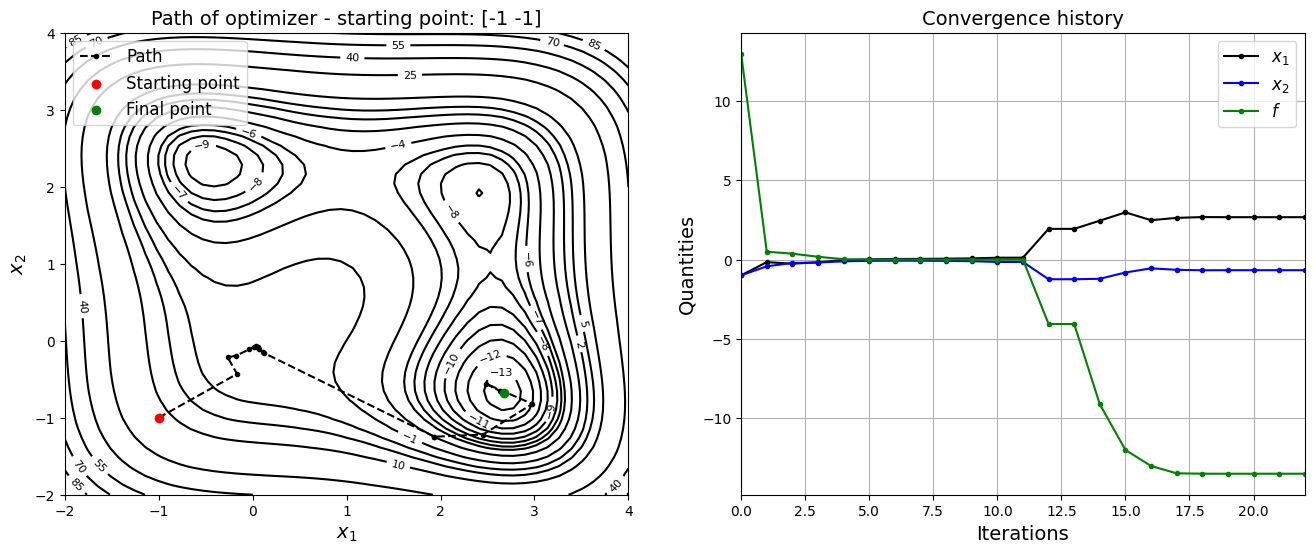

In [81]:
# Starting point 1
x0 = np.array([-1, -1])

# Defining dict for storing history of optimization
history = {}
history["x1"] = [x0[0]]
history["x2"] = [x0[1]]
history["f"] = [jones_function(x0)]

# Minimize the function
result = minimize(fun=jones_function, x0=x0, method=method, jac=jac, callback=jones_opt_history, options=options)

# Print value of x
print("Value of x1 at optimum: {}".format(result.x[0]))
print("Value of x2 at optimum: {}".format(result.x[1]))

# Convergence plots
jones_opt_plots(history, x0, result)

Following table summarizes results of the above three optimizations:

| Starting point | $x_1^*$ | $x_2^*$ | $f(x_1^*, x_2^*)$ |
|----------------|--------|--------|---------------|
| (1.5, 3.5)     | 2.42388| 1.92189| -9.03120    |
| (-1, 0)        |-0.44947| 2.29275| -9.77696    |
| (-1, -1)       | 2.67321|-0.67589| -13.53203   |

As can be seen in the above table, optimization results are dependent on where we start due to the multi-modal nature of function. This is one of the motivation behind global optimization algorithms.